# Download dataset

In [ ]:
import gdown

# CamVid archive.zip file ID from Google Drive link
file_id = "1nfUiaZ_e_HReJEdrD6Ivl5_80k2eLInH"
output = "CamVid.zip"

# Construct URL and download the file
url = f"https://drive.google.com/uc?id={file_id}"
gdown.download(url, output, quiet=False)

print(f"File downloaded and saved to: {output}")

# Unzip the downloaded dataset
!unzip -qo {output}

# List of extracted files/folders
!ls CamVid

Downloading...
From (original): https://drive.google.com/uc?id=1nfUiaZ_e_HReJEdrD6Ivl5_80k2eLInH
From (redirected): https://drive.google.com/uc?id=1nfUiaZ_e_HReJEdrD6Ivl5_80k2eLInH&confirm=t&uuid=97eb1433-f180-49fd-9d3f-79f3d8424506
To: /content/CamVid.zip
100%|██████████| 603M/603M [00:13<00:00, 44.2MB/s]


File downloaded and saved to: CamVid.zip
class_dict.csv	test  test_labels  train  train_labels	val  val_labels


In [ ]:
# List files to confirm the dataset was extracted
import os

base_dir = "CamVid"
for foldername, subfolders, filenames in os.walk(base_dir):
    print(f" {foldername} - {len(filenames)} files")

 CamVid - 1 files
 CamVid/train - 369 files
 CamVid/val_labels - 100 files
 CamVid/val - 100 files
 CamVid/test_labels - 232 files
 CamVid/test - 232 files
 CamVid/train_labels - 369 files


# Function to create binary mask for road(1) and no road(0)

In [ ]:
import numpy as np

def create_binary_road_mask(label_img):
    # Convert label image from HWC to (H, W, 3) numpy array
    road_rgb = np.array([128, 64, 128])  # Road class RGB
    mask = np.all(label_img == road_rgb, axis=-1).astype(np.uint8)
    return mask  # 1 where road, 0 elsewhere

# Set path and visualize the data

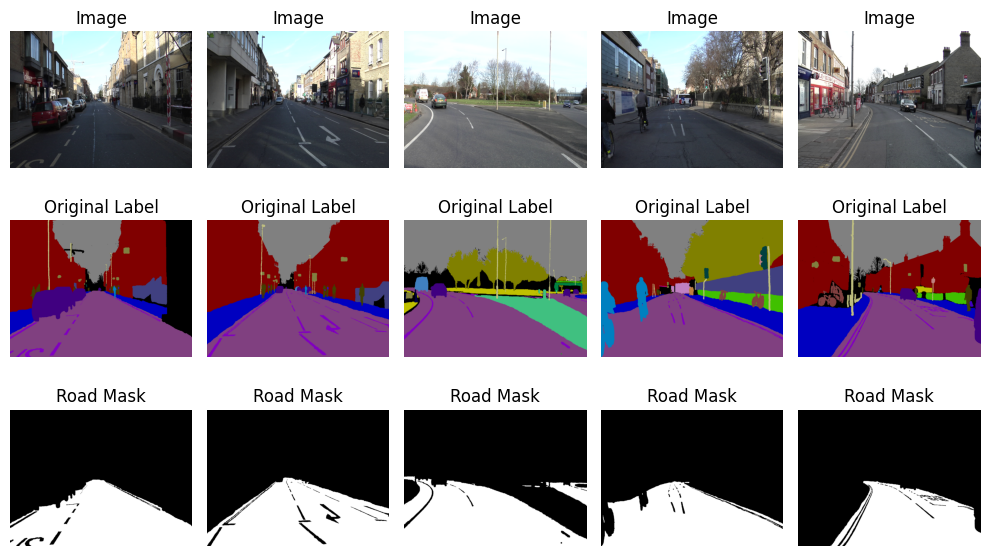

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import cv2

# Set image and label directories
image_dir = "CamVid/train"
label_dir = "CamVid/train_labels"

# Get sorted list of image and label files
image_files = sorted(os.listdir(image_dir))
label_files = sorted(os.listdir(label_dir))

# Choose 5 random indices
random_indices = random.sample(range(len(image_files)), 5)

# Plot random image-label pairs
plt.figure(figsize=(10, 6))
for i, idx in enumerate(random_indices):
    img_path = os.path.join(image_dir, image_files[idx])
    label_path = os.path.join(label_dir, label_files[idx])

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    label = cv2.imread(label_path)
    label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)

    binary_mask = create_binary_road_mask(label)

    # Show original image
    plt.subplot(3, 5, i + 1)
    plt.imshow(image)
    plt.title("Image")
    plt.axis('off')

    # Show label mask (RGB)
    plt.subplot(3, 5, i + 6)
    plt.imshow(label)
    plt.title("Original Label")
    plt.axis('off')

    # Show binary road mask
    plt.subplot(3, 5, i + 11)
    plt.imshow(binary_mask, cmap='gray')
    plt.title("Road Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Identify unique colors in label mask

In [ ]:
import pandas as pd

class_dict = pd.read_csv("CamVid/class_dict.csv")
print(class_dict)


                 name    r    g    b
0              Animal   64  128   64
1             Archway  192    0  128
2           Bicyclist    0  128  192
3              Bridge    0  128   64
4            Building  128    0    0
5                 Car   64    0  128
6     CartLuggagePram   64    0  192
7               Child  192  128   64
8         Column_Pole  192  192  128
9               Fence   64   64  128
10       LaneMkgsDriv  128    0  192
11    LaneMkgsNonDriv  192    0   64
12          Misc_Text  128  128   64
13  MotorcycleScooter  192    0  192
14        OtherMoving  128   64   64
15       ParkingBlock   64  192  128
16         Pedestrian   64   64    0
17               Road  128   64  128
18       RoadShoulder  128  128  192
19           Sidewalk    0    0  192
20         SignSymbol  192  128  128
21                Sky  128  128  128
22     SUVPickupTruck   64  128  192
23        TrafficCone    0    0   64
24       TrafficLight    0   64   64
25              Train  192   64  128
2

# Preprocess Image & Mask (Resize + Normalize)

In [ ]:
def preprocess_image_and_mask(img_path, mask_path, size=(256, 256)):
    image = cv2.imread(img_path)
    image = cv2.resize(image, size)
    image = image / 255.0  # normalize image to 0-1

    mask = cv2.imread(mask_path)
    mask = cv2.resize(mask, size)
    mask = create_binary_road_mask(mask)
    mask = np.expand_dims(mask, axis=-1)  # make shape (H, W, 1)

    return image, mask


# Function to load data

In [ ]:
import os
import numpy as np
from glob import glob

def load_data(image_dir, label_dir, preprocess_fn):
    """
    Loads and preprocesses image-mask pairs from directories.

    Parameters:
        image_dir (str): Path to the image directory.
        label_dir (str): Path to the label/mask directory.
        preprocess_fn (function): Function to preprocess image and mask.

    Returns:
        Tuple of NumPy arrays: (images, masks)
    """
    image_paths = sorted(glob(os.path.join(image_dir, "*.png")))
    mask_paths = sorted(glob(os.path.join(label_dir, "*.png")))

    images = []
    masks = []

    for img_path, mask_path in zip(image_paths, mask_paths):
        img, mask = preprocess_fn(img_path, mask_path)
        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)


In [ ]:
image_dir_train = "CamVid/train"
label_dir_train = "CamVid/train_labels"

X, Y = load_data(image_dir_train, label_dir_train, preprocess_image_and_mask)
print("Train Images shape:", X.shape)
print("Train Masks shape:", Y.shape)

image_dir_test = "CamVid/test"
label_dir_test = "CamVid/test_labels"

X_test, Y_test = load_data(image_dir_test, label_dir_test, preprocess_image_and_mask)
print("Test Images shape:", X_test.shape)
print("Test Masks shape:", Y_test.shape)

image_dir_val = "CamVid/val"
label_dir_val = "CamVid/val_labels"

X_val, Y_val = load_data(image_dir_val, label_dir_val, preprocess_image_and_mask)
print("Val Images shape:", X_val.shape)
print("Val Masks shape:", Y_val.shape)


Train Images shape: (369, 256, 256, 3)
Train Masks shape: (369, 256, 256, 1)
Test Images shape: (232, 256, 256, 3)
Test Masks shape: (232, 256, 256, 1)
Val Images shape: (100, 256, 256, 3)
Val Masks shape: (100, 256, 256, 1)


# U-NET Architecture of neural networks

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models


In [ ]:
def get_unet_model(input_shape=(256, 256, 3)):
    inputs = tf.keras.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    c3 = layers.Dropout(0.3)(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottle-neck
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    c4 = layers.Dropout(0.3)(c4)

    # Decoder
    u1 = layers.UpSampling2D((2, 2))(c4)
    u1 = layers.Concatenate()([u1, c3])
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    u2 = layers.UpSampling2D((2, 2))(c5)
    u2 = layers.Concatenate()([u2, c2])
    c6 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u2)
    c6 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c6)

    u3 = layers.UpSampling2D((2, 2))(c6)
    u3 = layers.Concatenate()([u3, c1])
    c7 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u3)
    c7 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c7)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)

    return models.Model(inputs, outputs)


In [ ]:
model = get_unet_model()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_105 (Conv2D) │ (None, 256, 256,  │        448 │ input_layer_7[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_106 (Conv2D) │ (None, 256, 256,  │      2,320 │ conv2d_105[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 128, 128,  │          0 │ conv2d_106[0][0]  │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_107 (Conv2D) │ (None, 128, 128,  │      4,640 │ max_pooling2d_21… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_108 (Conv2D) │ (None, 128, 128,  │      9,248 │ conv2d_107[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_22    │ (None, 64, 64,    │          0 │ conv2d_108[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_109 (Conv2D) │ (None, 64, 64,    │     18,496 │ max_pooling2d_22… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_110 (Conv2D) │ (None, 64, 64,    │     36,928 │ conv2d_109[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 64, 64,    │          0 │ conv2d_110[0][0]  │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_23    │ (None, 32, 32,    │          0 │ dropout_14[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_111 (Conv2D) │ (None, 32, 32,    │     73,856 │ max_pooling2d_23… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_112 (Conv2D) │ (None, 32, 32,    │    147,584 │ conv2d_111[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 32, 32,    │          0 │ conv2d_112[0][0]  │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_21    │ (None, 64, 64,    │          0 │ dropout_15[0][0]  │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_21      │ (None, 64, 64,    │          0 │ up_sampling2d_21… │
│ (Concatenate)       │ 192)              │            │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_113 (Conv2D) │ (None, 64, 64,    │    110,656 │ concatenate_21[0

 Total params: 487,297 (1.86 MB)

 Trainable params: 487,297 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

# Training Data

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    filepath='best_model.keras',           # where to save the model
    monitor='val_accuracy',             # what metric to monitor
    mode='max',                         # maximize val_accuracy
    save_best_only=True,                # only save when val_accuracy improves
    verbose=1
)


history = model.fit(
    X,
    Y,
    validation_data=(X_val, Y_val),
    epochs=30,
    batch_size=16,
    callbacks=[checkpoint]
)

Epoch 1/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.6595 - loss: 0.5606
Epoch 1: val_accuracy improved from -inf to 0.71767, saving model to best_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 368ms/step - accuracy: 0.6612 - loss: 0.5569 - val_accuracy: 0.7177 - val_loss: 0.3377
Epoch 2/30
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.7555 - loss: 0.3261
Epoch 2: val_accuracy improved from 0.71767 to 0.91669, saving model to best_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.7600 - loss: 0.3254 - val_accuracy: 0.9167 - val_loss: 0.2886
Epoch 3/30
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9152 - loss: 0.2883
Epoch 3: val_accuracy did not improve from 0.91669
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.9154 - loss: 0.2881 - val_accuracy: 0.8916 - val_loss: 0.3251
Epoch 4/30
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9115 - loss: 0.2796
Epoch 4: val_accuracy improved from 0.91669 to 0.93621, saving model to best_m

# Evaluating the model and visualize the results

In [ ]:
from tensorflow.keras.models import load_model

best_model = load_model('best_model.keras')

In [ ]:
import matplotlib.pyplot as plt

def plot_sample_prediction(index):
    img = X_test[index]
    true_mask = Y_test[index].squeeze()
    pred_mask = best_model.predict(img[np.newaxis, ...])[0].squeeze()
    pred_mask_binary = (pred_mask > 0.5).astype(np.uint8)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title("True Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask_binary, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step


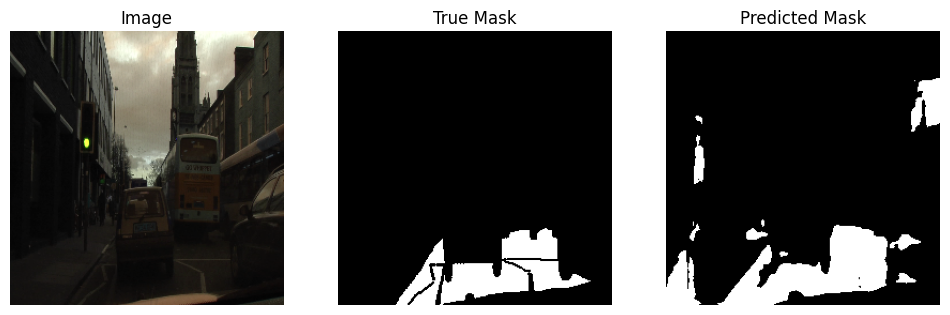

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


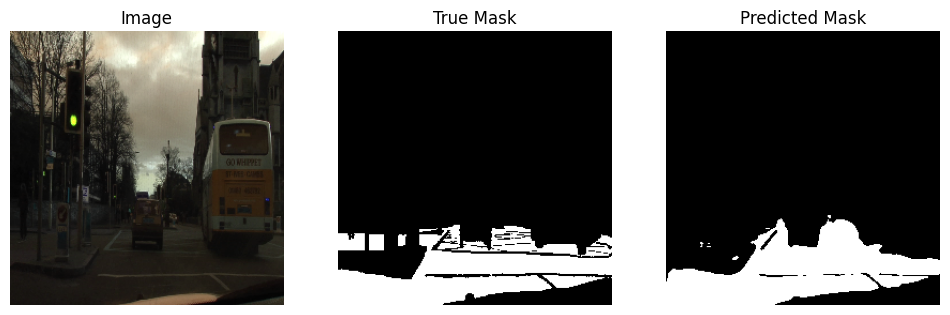

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


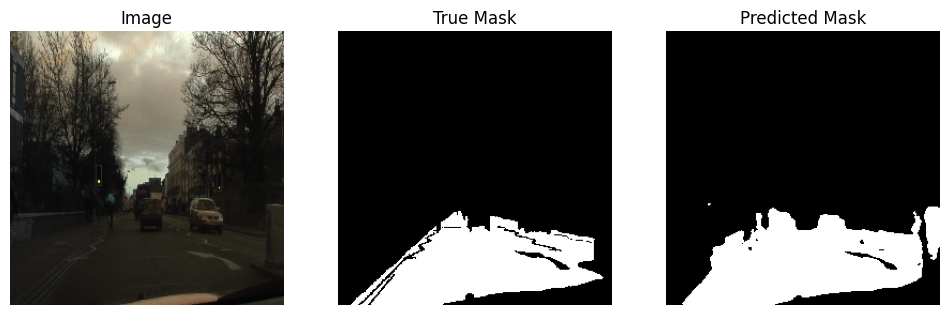

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


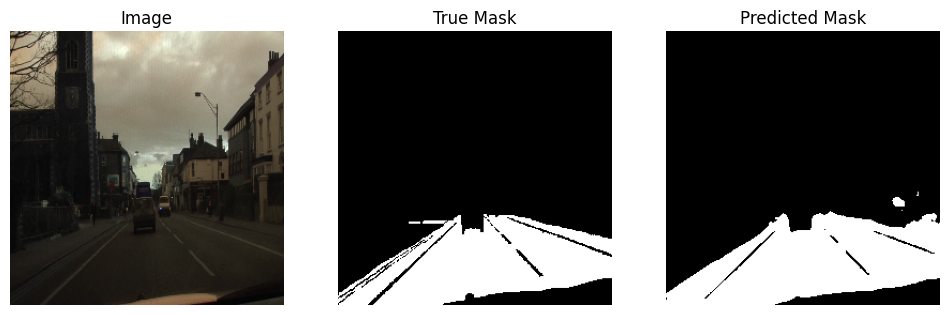

In [ ]:
for i in [0, 10, 20, 30]:
  plot_sample_prediction(i)

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.9668 - loss: 0.0903
Test Loss: 0.0779
Test Accuracy: 0.9705


# Comparing training and validation (accuracy & loss)

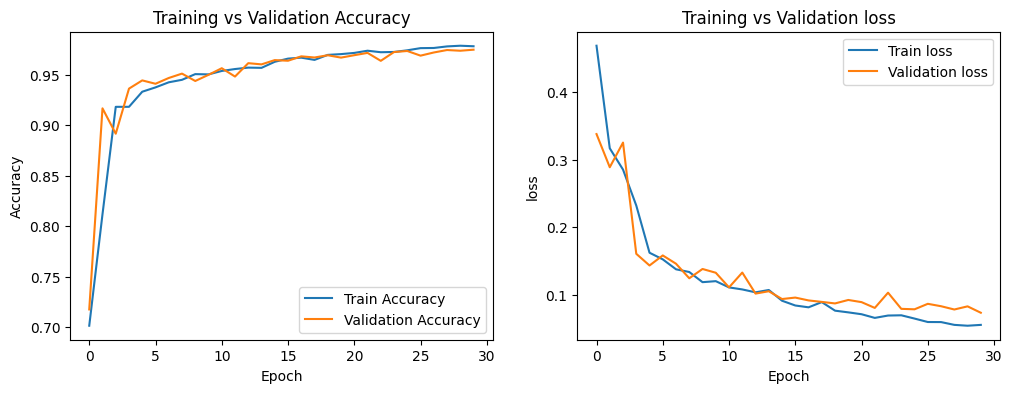

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title("Training vs Validation loss")
plt.xlabel("Epoch")
plt.ylabel("loss")

plt.show()

# Evaluation using IoU metrics

In [ ]:
import numpy as np

# Function to calculate IoU for a single image
def calculate_iou(true_mask, predicted_mask):
    """
    Calculates Intersection over Union (IoU) between two binary masks.
    """
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)
    true_mask = true_mask.astype(np.uint8)

    intersection = np.logical_and(true_mask, predicted_mask).sum()
    union = np.logical_or(true_mask, predicted_mask).sum()

    if union == 0:
        return 0.0
    else:
        return intersection / union

# Predict masks using the trained model
predicted_masks = best_model.predict(X_test)

# Calculate IoU for each image
ious = []

for i in range(len(X_test)):
    true_mask = Y_test[i].squeeze()              # (H, W)
    pred_mask = predicted_masks[i].squeeze()     # (H, W)

    iou = calculate_iou(true_mask, pred_mask)
    ious.append(iou)

# Calculate the mean IoU score
mean_iou = np.mean(ious)

print("Mean IoU on Test Set:", round(mean_iou, 4))


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step
Mean IoU on Test Set: 0.8752


In [ ]:
# for i, score in enumerate(ious):
#     print(f"Image {i}: IoU = {round(score, 4)}")


# Testing on self-clicked images

### Download Self clicked images

In [ ]:
import gdown

# self_click_images.zip file ID from Google Drive link
file_id = "1VReu3RdeKDRgS_1ZUctyhb8DdSO1QhZD"
output = "self_click_images.zip"

# Construct URL and download the file
url = f"https://drive.google.com/uc?id={file_id}"
gdown.download(url, output, quiet=False)

print(f"File downloaded and saved to: {output}")

# Unzip the folder
!unzip -qo {output}

# List of extracted images
!ls self_click_images

Downloading...
From: https://drive.google.com/uc?id=1VReu3RdeKDRgS_1ZUctyhb8DdSO1QhZD
To: /content/self_click_images.zip
100%|██████████| 1.53M/1.53M [00:00<00:00, 13.2MB/s]


File downloaded and saved to: self_click_images.zip
road1.jpg  road2.jpg  road3.jpg  road4.jpg  road5.jpg  road6.jpg  road7.jpg


# Preprocess them

In [ ]:
from PIL import Image
import numpy as np
# Path to the extracted folder
folder_path = "/content/self_click_images"

def preprocess_image(image_path):
    img = Image.open(image_path).convert("RGB")
    img = img.resize((256, 256))  # Resiszing to 256x256, matching the input size of model
    img = np.array(img) / 255.0   # Normalize to [0, 1]
    return img[np.newaxis, ...]   # Add batch dimension



# Uses trained model for prediction on self clicked images

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


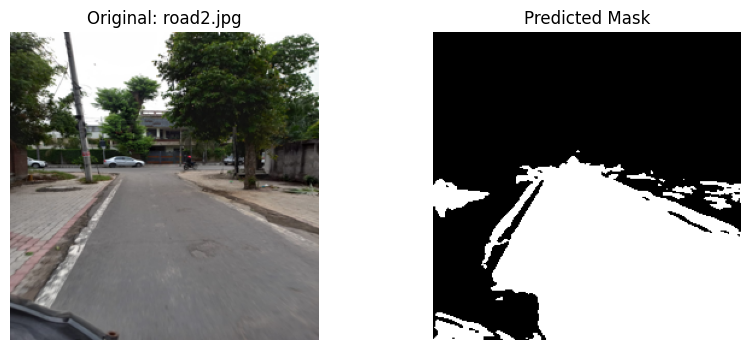

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


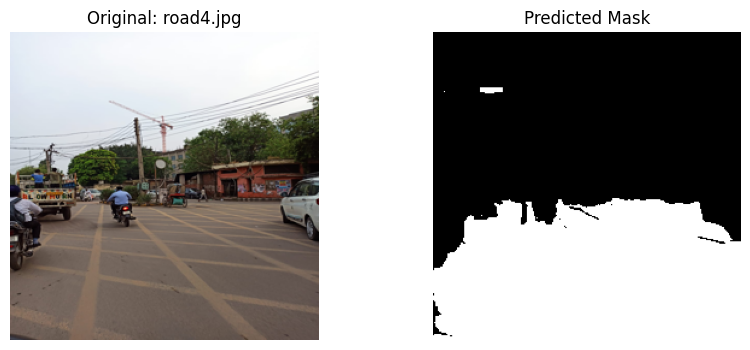

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


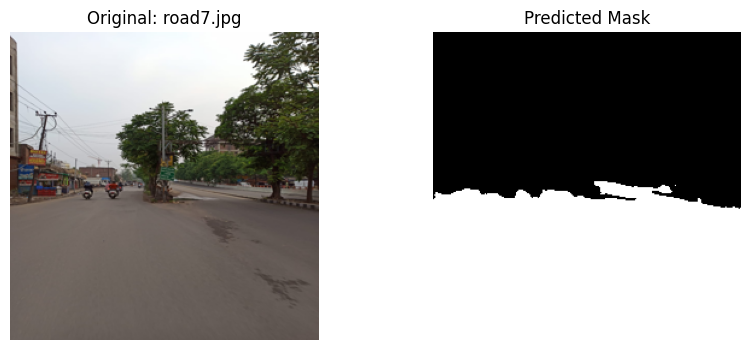

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


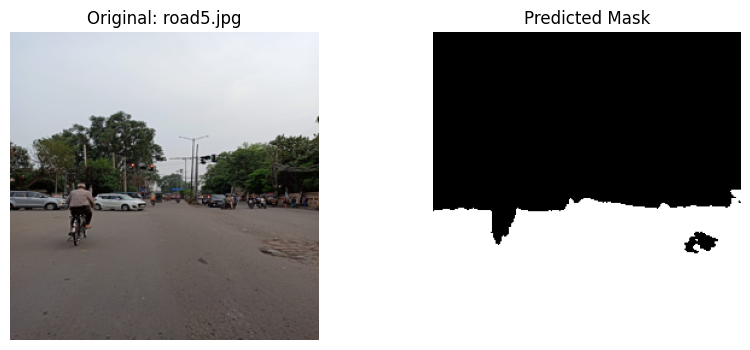

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


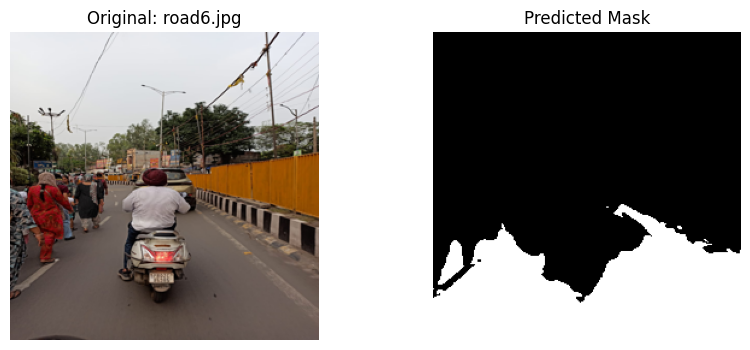

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


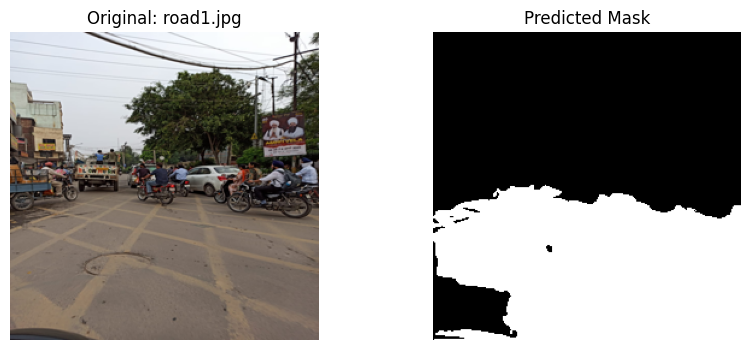

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


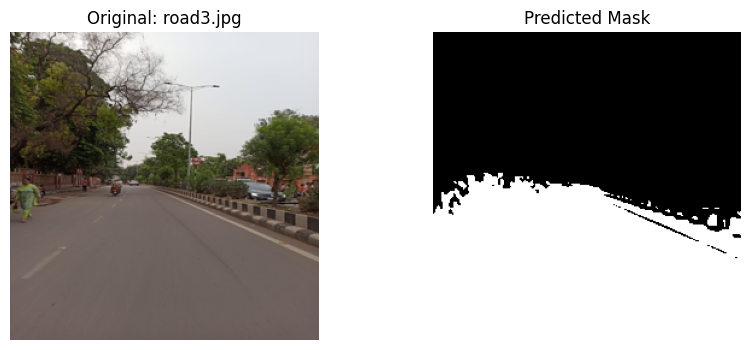

In [ ]:
# List all image files in the folder
image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg'))]

for file_name in image_files:
    image_path = os.path.join(folder_path, file_name)

    # Preprocess the image
    input_image = preprocess_image(image_path)

    # Predict the mask using your trained U-Net model
    prediction = model.predict(input_image)[0].squeeze()
    binary_mask = (prediction > 0.5).astype(np.uint8)

    # Show results
    plt.figure(figsize=(10, 4))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(Image.open(image_path).resize((256, 256)))
    plt.title("Original: " + file_name)
    plt.axis("off")

    # Predicted road mask
    plt.subplot(1, 2, 2)
    plt.imshow(binary_mask, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()


# Assign weights to each pixel of an image

### create a weight map, where:
### Pixels near the edge = weight = 5 (important),
### Other pixels = weight = 1 (normal).


In [ ]:
def get_edge_weight(mask):
    """
    Gives higher weight to edge pixels in the mask.
    Input: mask - 2D array with 0 (background) and 1 (road)
    Output: weight map - same size, with 1 for normal pixels and 5 for edge pixels
    """
    mask = (mask * 255).astype('uint8')          # Convert to 0–255 for edge detection
    mask = np.where(mask > 0, 1, 0).astype('uint8') * 255
    edges = cv2.Canny(mask, 100, 200)            # Find edges
    weights = np.ones_like(mask, dtype='float32')  # Start with weight = 1 everywhere
    weights[edges > 0] = 5.0                     # Give edge pixels weight = 5
    return weights


# Apply weighted function to all the training and validation masks

In [ ]:
def create_all_weights(masks):
    weight_maps = []
    for mask in masks:
        weight = get_edge_weight(mask[..., 0])      # Get 2D mask
        weight_maps.append(weight[..., np.newaxis]) # Add channel back
    return np.array(weight_maps, dtype='float32')

# Generate weight maps
train_weights = create_all_weights(Y)
val_weights = create_all_weights(Y_val)


# Compile the model and train it using the above weights

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train with sample_weight
model.fit(X, Y, sample_weight=train_weights,
          validation_data=(X_val, Y_val, val_weights),
          epochs=20, batch_size=16)


Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 425ms/step - accuracy: 0.9325 - loss: 0.2810 - val_accuracy: 0.9603 - val_loss: 0.1616
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 0.9641 - loss: 0.1475 - val_accuracy: 0.9719 - val_loss: 0.1320
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9756 - loss: 0.1149 - val_accuracy: 0.9732 - val_loss: 0.1308
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9784 - loss: 0.1038 - val_accuracy: 0.9744 - val_loss: 0.1243
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.9780 - loss: 0.1044 - val_accuracy: 0.9731 - val_loss: 0.1324
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9795 - loss: 0.0997 - val_accuracy: 0.9754 - val_loss: 0.1220
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.9809 - loss: 0.0960 - val_accuracy: 0.9758 - val_loss: 0.1253
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.9810 - loss: 0.0952 - val_accuracy: 0

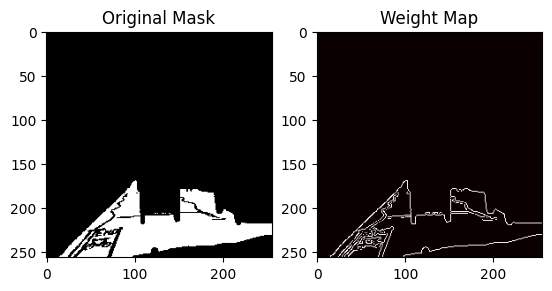

In [ ]:
import matplotlib.pyplot as plt

idx = 10
plt.subplot(1, 2, 1)
plt.imshow(Y[idx, ..., 0], cmap='gray')
plt.title('Original Mask')

plt.subplot(1, 2, 2)
plt.imshow(train_weights[idx, ..., 0], cmap='hot')
plt.title('Weight Map')
plt.show()


# Evaluate validation accuracy and loss

In [ ]:
loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.9735 - loss: 0.0846
Test Loss: 0.0740
Test Accuracy: 0.9762


# Evaluate using IOU

In [ ]:
def compute_iou(y_true, y_pred):
    y_true = y_true.astype(bool)
    y_pred = y_pred.astype(bool)
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    iou = intersection / union if union != 0 else 1.0
    return iou

# Predict masks
preds = model.predict(X_val)
preds_binary = (preds > 0.5).astype('uint8')

# # Compute IoU for a few samples
# for i in range(5):
#     iou = compute_iou(Y_val[i], preds_binary[i])
#     print(f"Sample {i} IoU: {iou:.4f}")

ious = []

for i in range(len(Y_val)):
    iou = compute_iou(Y_val[i], preds_binary[i])
    ious.append(iou)

mean_iou = np.mean(ious)
print(f"Mean IoU on validation set: {mean_iou:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step
Mean IoU on validation set: 0.9220


# Visualizing the predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


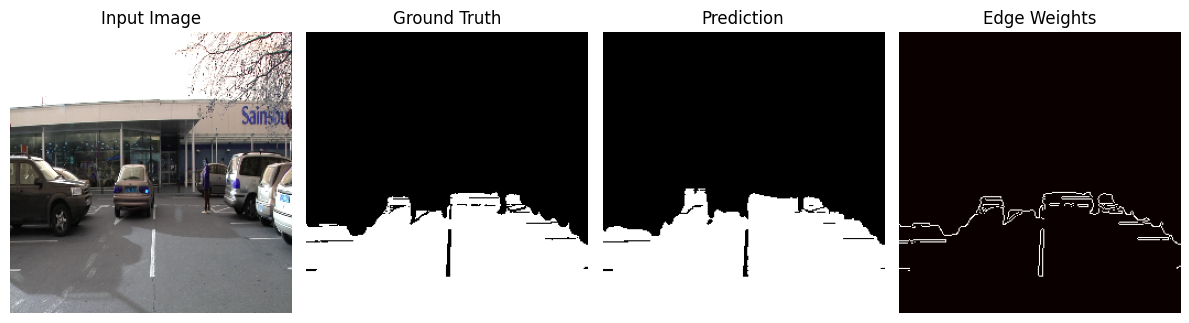

In [ ]:
import matplotlib.pyplot as plt

def show_prediction(i):
    image = X_val[i]
    true_mask = Y_val[i].squeeze()
    pred_mask = (model.predict(image[np.newaxis])[0].squeeze() > 0.5).astype('uint8')
    weight_map = val_weights[i].squeeze()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 4, 1)
    plt.imshow(image)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("Prediction")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.imshow(weight_map, cmap='hot')
    plt.title("Edge Weights")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Show sample prediction
show_prediction(18)


# Visualizing model performance on self clicked images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


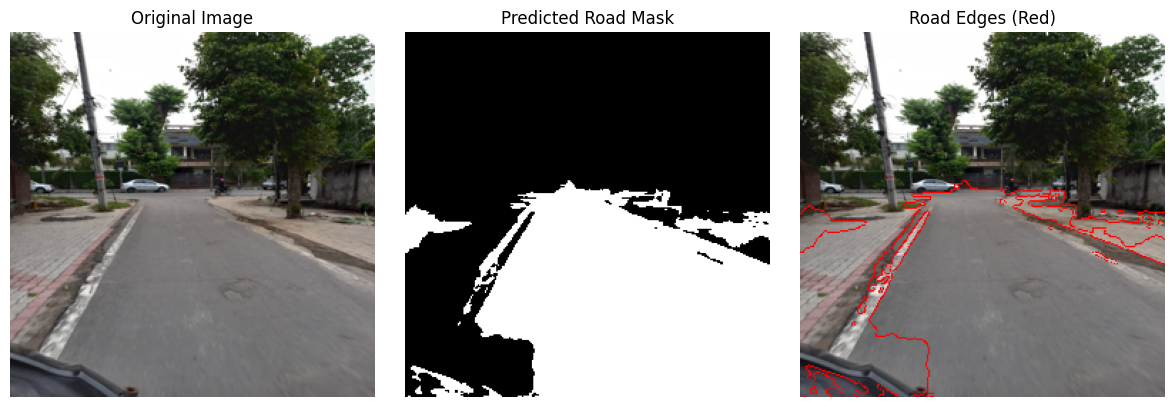

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


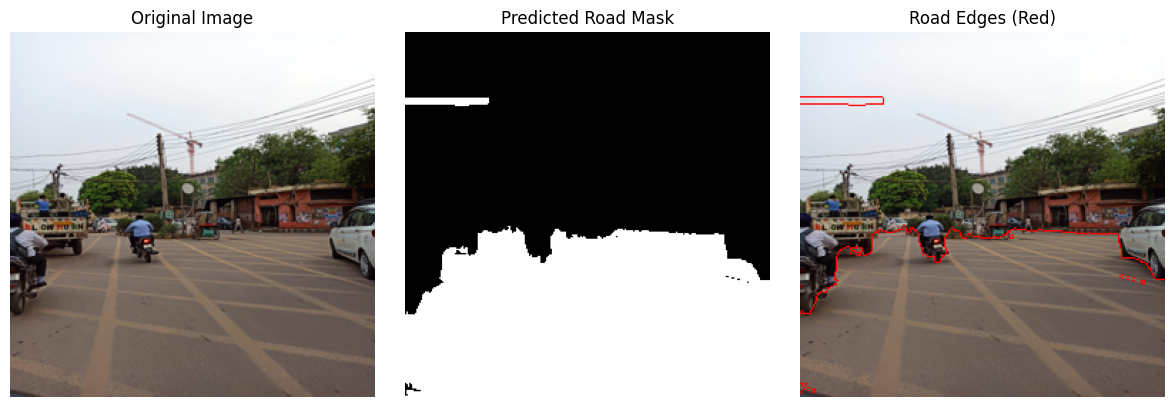

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


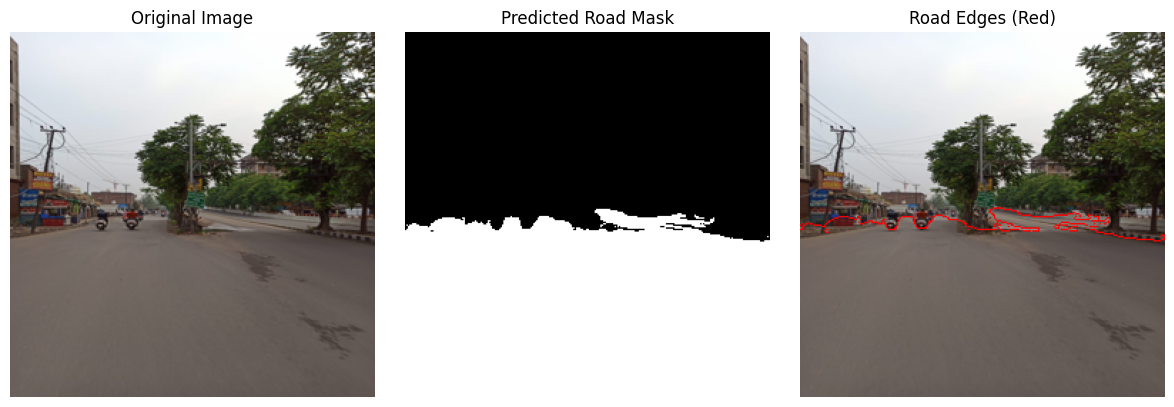

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


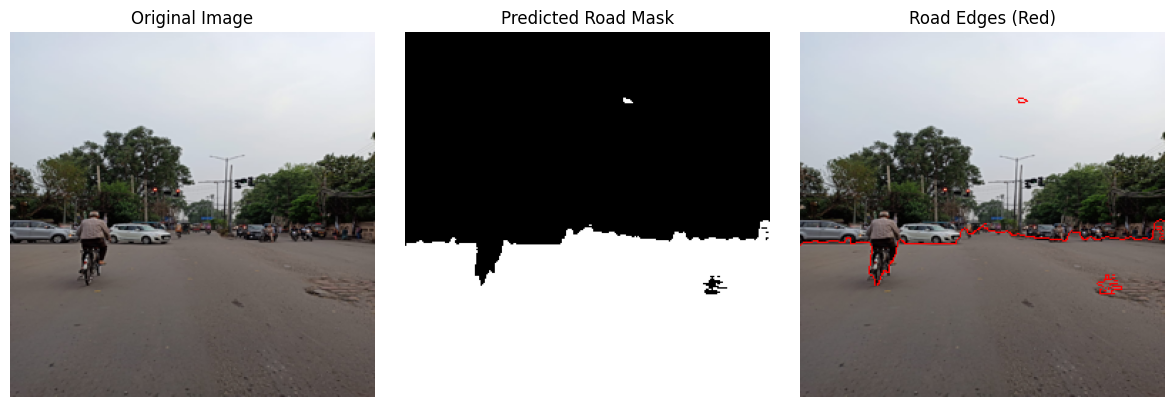

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


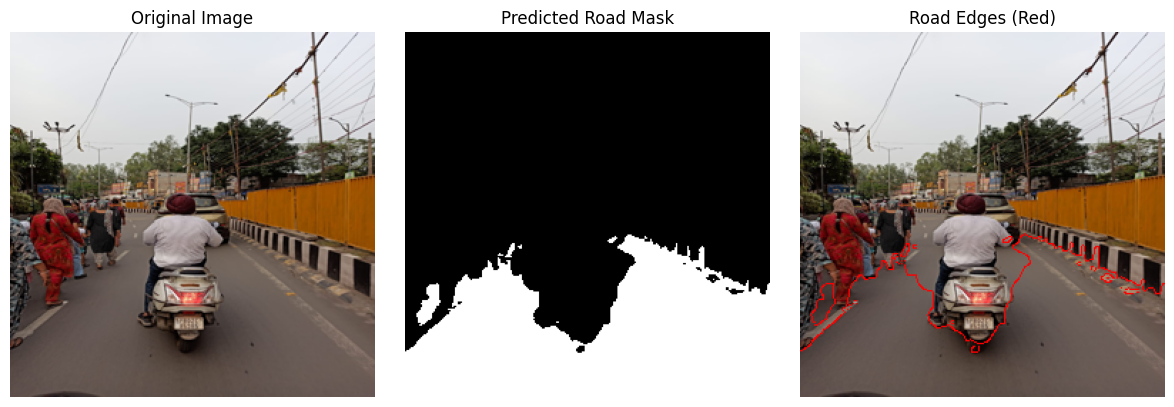

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


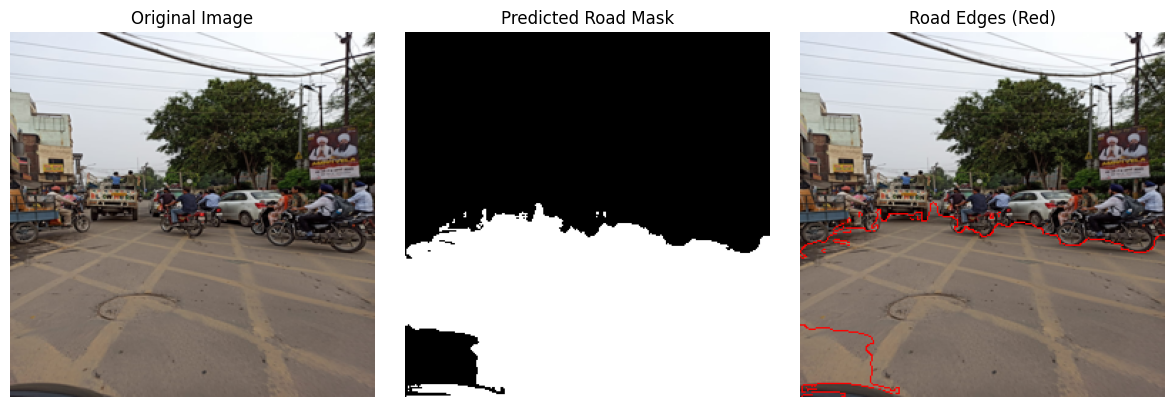

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


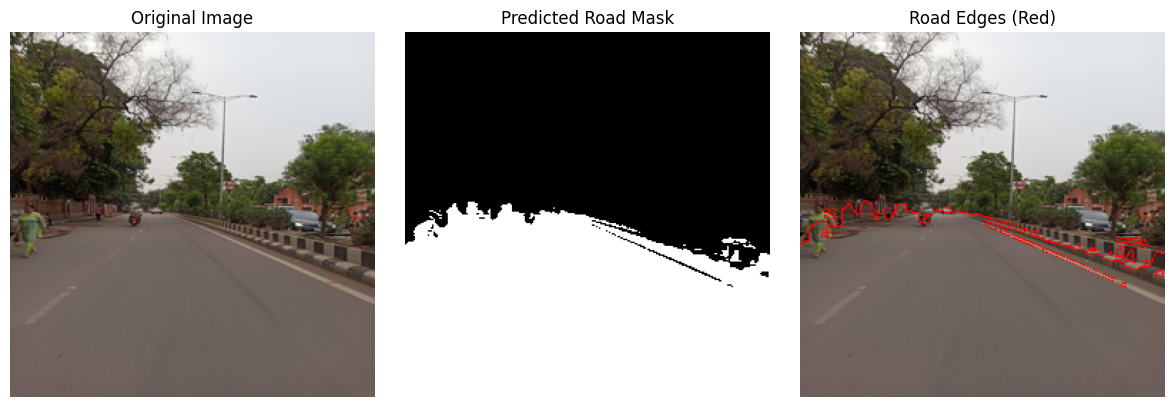

In [ ]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

folder_path = "/content/self_click_images"

# Loop through all image files
for file_name in os.listdir(folder_path):
    if file_name.endswith(".jpg"):
        image_path = os.path.join(folder_path, file_name)

        # Load and preprocess image
        img = Image.open(image_path).convert("RGB").resize((256, 256))
        img_array = np.array(img) / 255.0
        input_image = img_array[np.newaxis, ...]

        # Predict road mask using your trained edge-aware model
        prediction = model.predict(input_image)[0].squeeze()
        predicted_mask = (prediction > 0.5).astype(np.uint8)

        # Get road edges using Canny
        mask_uint8 = (predicted_mask * 255).astype('uint8')
        road_edges = cv2.Canny(mask_uint8, 100, 200)

        # Overlay road edges (in red) on the original image
        overlay_img = np.array(img).copy()
        overlay_img[road_edges > 0] = [255, 0, 0]  # Red edges

        # Show all outputs side-by-side
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(predicted_mask, cmap='gray')
        plt.title("Predicted Road Mask")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(overlay_img)
        plt.title("Road Edges (Red)")
        plt.axis("off")

        plt.tight_layout()
        plt.show()


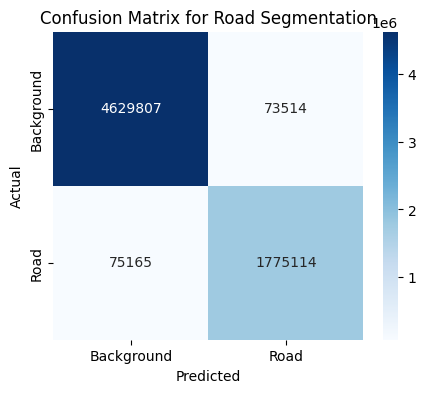

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Flatten all predictions and ground truths
y_true_flat = np.concatenate([Y_val[i].flatten() for i in range(len(Y_val))])
y_pred_flat = np.concatenate([preds_binary[i].flatten() for i in range(len(preds_binary))])

# Compute confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat)

# Plot
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Background', 'Road'], yticklabels=['Background', 'Road'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Road Segmentation")
plt.show()
